In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy

from neurodynex3.hopfield_network import plot_tools

#import custom made hopfield network functions from Q1

'''

Please ensure the ipynb package is installed in the environment or the following imports won't work! Use:
'pip install ipynb'

Also install scikit-learn:
'pip install -U scikit-learn'

'''
from ipynb.fs.defs.Q1 import *
from sklearn.metrics import f1_score  

# download (if necessary) and import the mnist dataset
import mnist

**Note:** Need internet to run the following cell for the first time which loads the mnist dataset

In [3]:

train_img = mnist.train_images()
train_lab = mnist.train_labels()

test_img = mnist.test_images()
test_lab = mnist.test_labels()

print(train_img.shape, test_img.shape)

(60000, 28, 28) (10000, 28, 28)


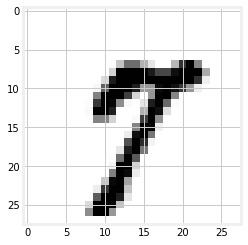

Label: 7


In [4]:
#Sample data and label

%matplotlib inline 
i =  np.random.randint(60000)

plt.imshow(train_img[i,:,:], cmap = 'gray_r', vmin=0, vmax = 255, interpolation = 'nearest')
plt.show()

print('Label: ' + str(train_lab[i]))


## Q3: Function to convert mnist data into usable form for our custom made Hopfield Network: 



In [5]:
#Function to convert mnist data into usable form for our custom made Hopfield Network
def convert_binary(image_arr, threshold = 85):
    shapes = np.shape(image_arr)
    
    out_arr = np.zeros(shapes)
    
    for index, x in np.ndenumerate(image_arr):
        if x < threshold:
            out_arr[index] = -1
        else:
            out_arr[index] = 1
    
    return out_arr

#Function to display converted img:
def display_img(image):
    
    plt.imshow(image, cmap = 'gray_r', interpolation = 'nearest')
    plt.show()
    


## Demo  showing the above works

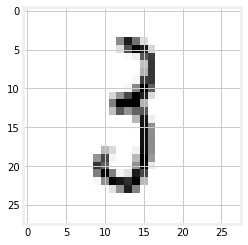

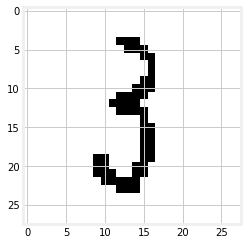

In [7]:
#threshhold to turn pixel black
thresh = 85

#mnist image:
%matplotlib inline 
i =  np.random.randint(60000)

display_img(train_img[i])


#converted image:
display_img(convert_binary(train_img[i], thresh))

# Q4: Training and Testing Hopfield Network on MNIST

The following is the most critical cell. Threshold used to convert the images into binary has a **big** impact on everything that follows. Threshold can be any value from 0 to 255. 

In [192]:
#Hyperparameters:

thresh = 85 #threshold to conver to binary
train_img_per_digit = 10 #how many images will be memorized per digit 
samples_per_img = 200 # how many random images will be averaged over to make one image to be memorized
res = 28 #resolution

total_samples = 10*train_img_per_digit*samples_per_img #total samples to be used from MNIST train set

Getting a training set in suitable form:

In [193]:
#Getting the raw training set
train_set = np.zeros((10,train_img_per_digit, 28, 28))
random_labels = np.random.choice(60000, total_samples, replace = False) 

for run in range(train_img_per_digit):
    temp_set = np.zeros((10, 28, 28))
    temp_set1 = np.zeros((10, 28, 28))
    count_set = np.zeros(10)

    ran_idx = random_labels[(run*10*samples_per_img):((run+1)*10*samples_per_img)]

    for i in ran_idx:
        label = train_lab[i]
        count_set[label] += 1

        temp_set[label, :, :] += train_img[i]


    for i in range(10):
        temp_set1[i,:,:]  = temp_set[i,:,:]/count_set[i]

    train_set[:,run,:,:] = temp_set1

#Converting to binary:
train_set_bin = np.zeros((10, train_img_per_digit, 28, 28))

for i in range(10):
    for j in range(train_img_per_digit):
        train_set_bin[i,j,:,:] = convert_binary(train_set[i,j,:,:], thresh)

#Finally converting the usable format to intialize hopfield:
mnist_patterns = np.zeros((10*train_img_per_digit, 28, 28))

for i in range(10):
    for j in range(train_img_per_digit):
        mnist_patterns[(train_img_per_digit*i + j), :, :] = train_set_bin[i,j]


In [194]:
np.shape(mnist_patterns)

(100, 28, 28)

Run the following cell to see all the images to be memorized for a random digit

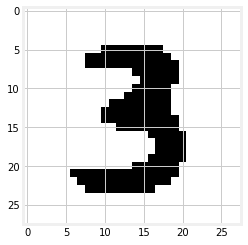

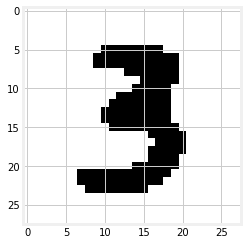

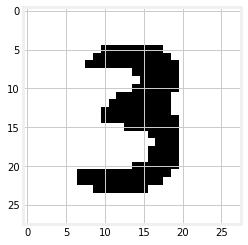

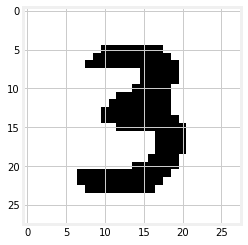

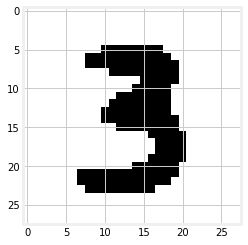

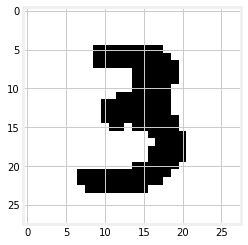

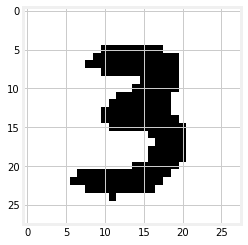

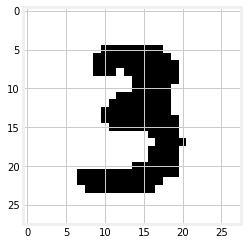

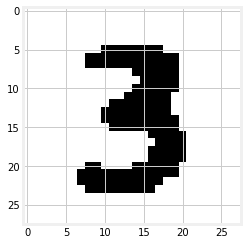

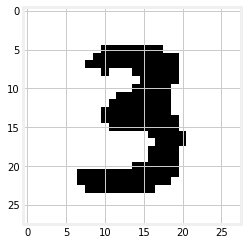

In [195]:
i = np.random.randint(10)
for k in range(train_img_per_digit):
    display_img(mnist_patterns[i*train_img_per_digit + k])


**More Helper Functions:**

In [196]:
#Function to change to 14x14 or 7x7 resolution:
def change_res(image, resolution=14):
    
    size0 = np.shape(image)[0]
    
    div = int(size0/resolution)
    out_temp = np.zeros((resolution,resolution))
    out_image = np.zeros((resolution,resolution))
    
    for i in range(resolution):
        for j in range(resolution):
            out_temp[i,j] = np.mean(image[i*div:(i+1)*div, j*div:(j+1)*div])
            
            if out_temp[i,j] >= 0:
                out_image[i,j] = 1
            else:
                out_image[i,j] = -1
            
    return out_image
    

    
# Update Hopfield Network ASYNCHRONOUSLY till convergence
def conv_hopfield_mnist(weights, cue, plot = True):
    cache = [cue]
    i = 0
    while True:
        #print(i)
        i+= 1
        temp = update_hopfield_async(weights, cache[-1], plot = False)
        if(i > 50):
            print('Too Long!')
            break
        
        if any(np.array_equal(temp,x) for x in cache):
            cache.append(temp)
            break
        else:
            cache.append(temp)
    
    #cache = np.array(cache)
    
    if plot == True:
        plot_tools.plot_pattern_list(cache)
    
    return cache

#function to classify a given cue/pattern as a digit:
def classify_mnist(mnist_patterns, image):
    N = np.shape(mnist_patterns)[0]
    img_per_digit = int(N/10)
    size = np.shape(mnist_patterns)[1]
    
    overlap_arr = np.zeros(10)
    
    for x in range(10):
        count = 0
        for k in range(img_per_digit):
            for i in range(size):
                for j in range(size):
                    if image[i,j] == mnist_patterns[x*img_per_digit + k, i, j]: 
                        count += 1

            overlap_arr[x] = count
        
    max_idx = np.argmax(overlap_arr)
    
    return max_idx
    
    
    

# Moment of Truth:

First a demo. The network classifies 1000 randomly chosen images from the training set itself:

In [197]:
#Initializing the network and storing weights:
mnist_weights = init_hopfield(mnist_patterns)
print('Reminder: Threshold used is ' + str(thresh))

Reminder: Threshold used is 85


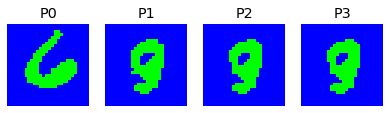

9


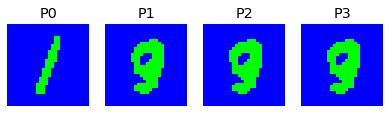

9


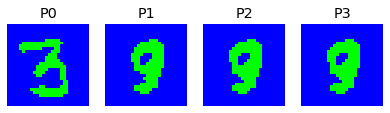

9


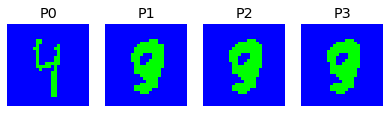

9


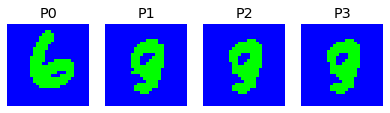

9


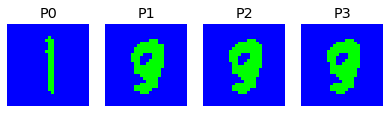

9


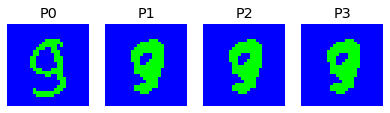

9


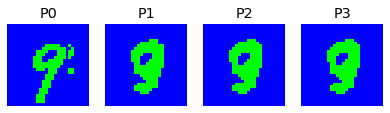

9


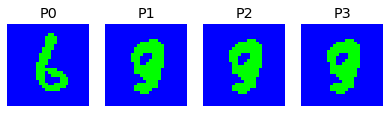

9


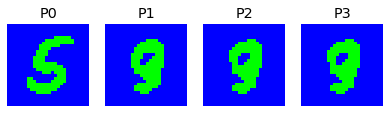

9


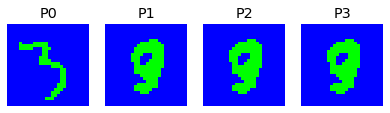

9


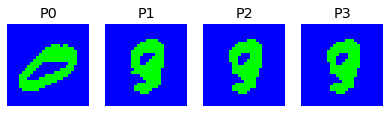

9


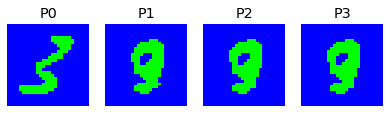

9


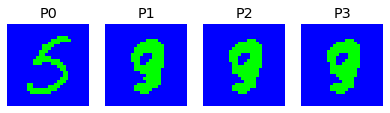

9


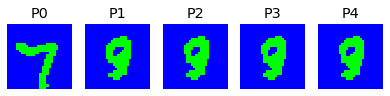

9


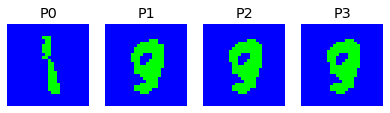

9


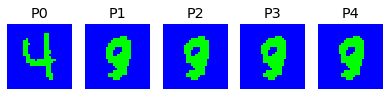

9


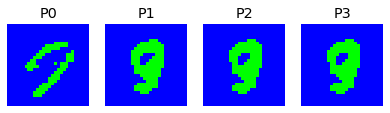

9


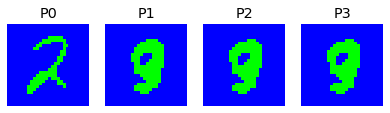

9


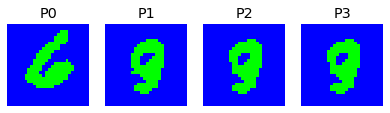

9


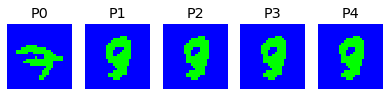

9


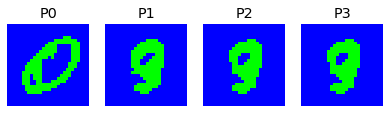

9


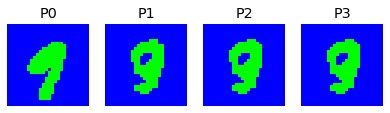

9


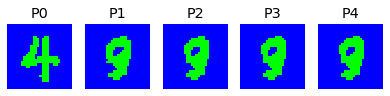

9


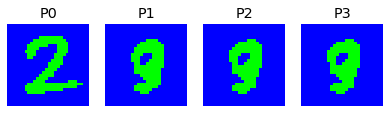

9


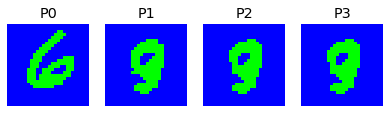

9


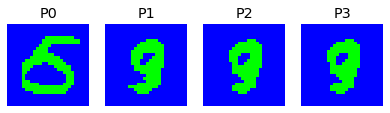

9


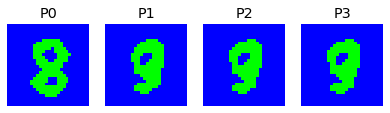

9


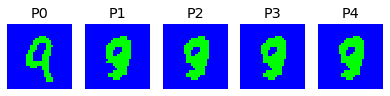

9


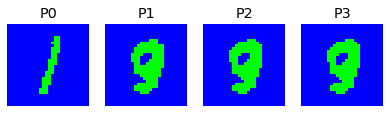

9


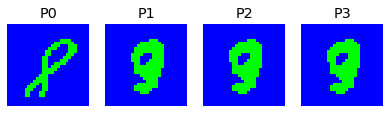

9


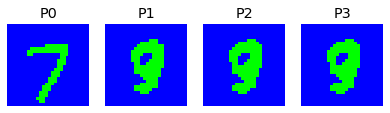

9


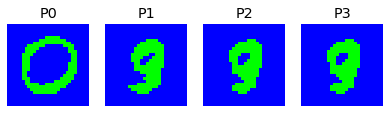

9


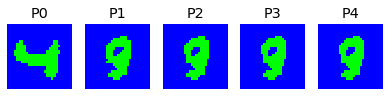

9


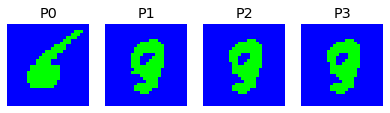

9


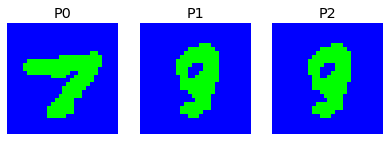

9


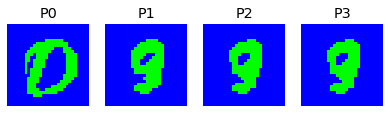

9


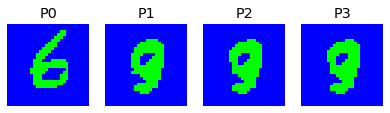

9


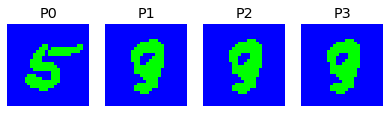

9


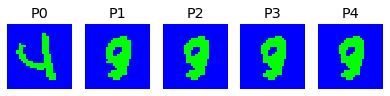

9


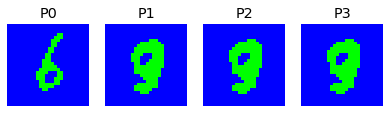

9


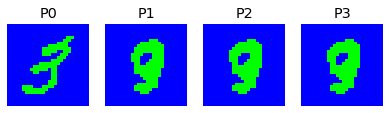

9


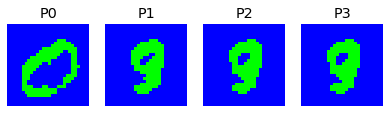

9


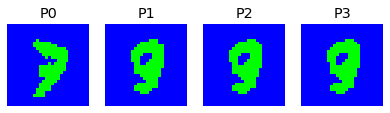

9


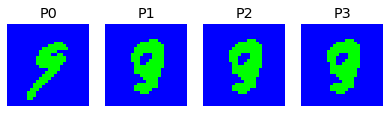

9


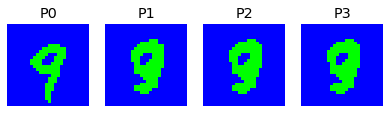

9


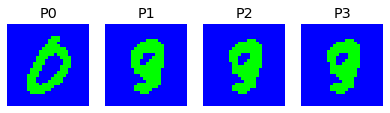

9


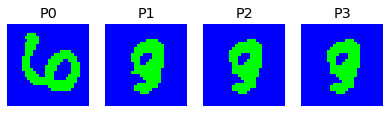

9


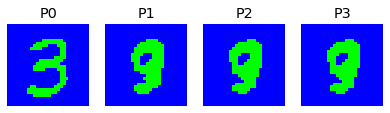

9


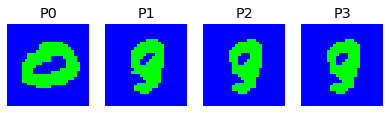

9


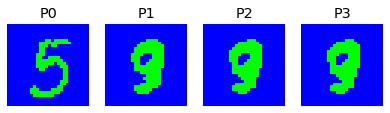

9


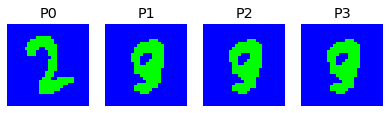

9


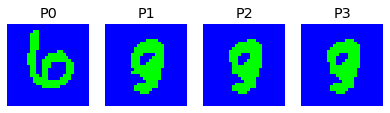

9


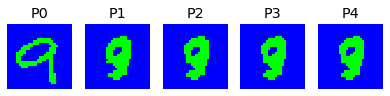

9


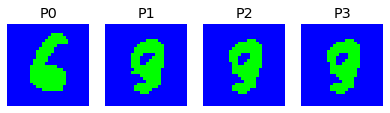

9


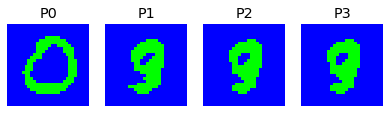

9


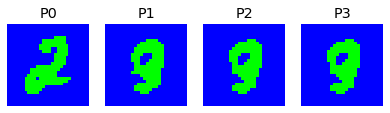

9


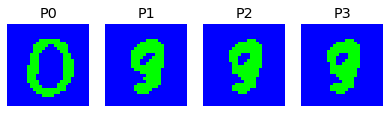

9


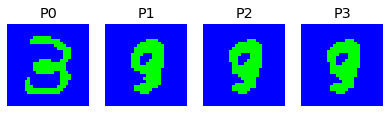

9


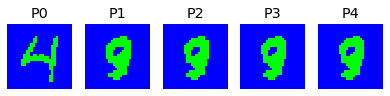

9


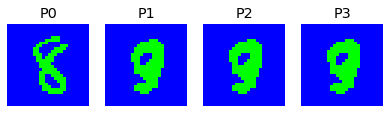

9


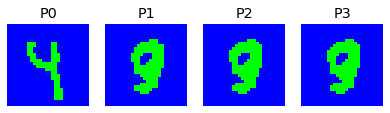

9


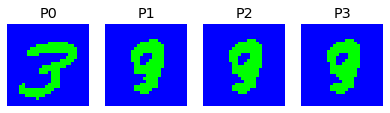

9


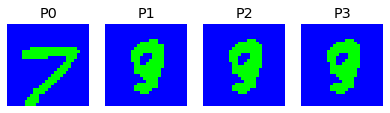

9


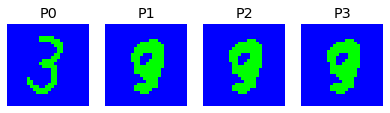

9


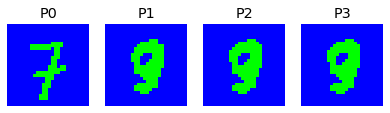

9


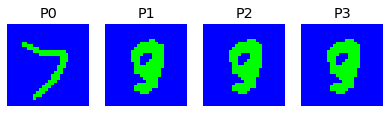

9


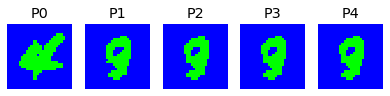

9


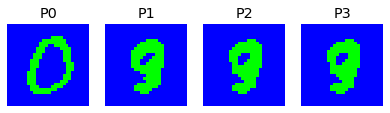

9


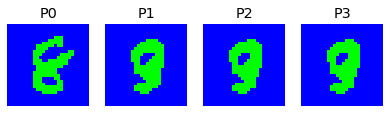

9


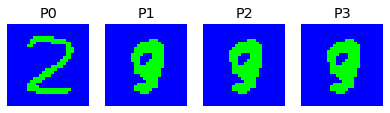

9


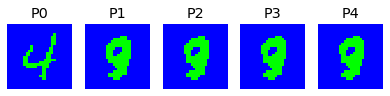

9


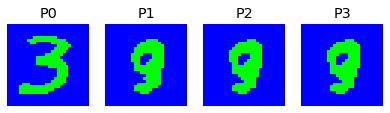

9


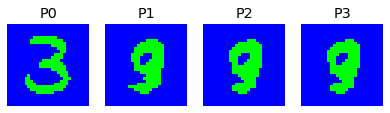

9


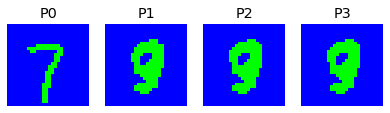

9


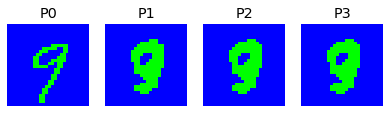

9


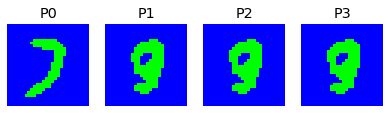

9


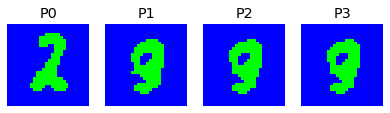

9


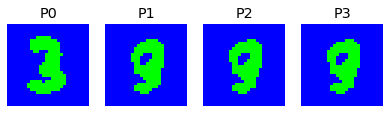

9


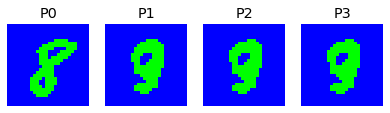

9


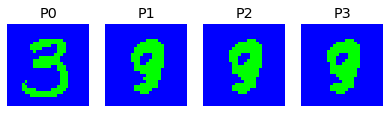

9


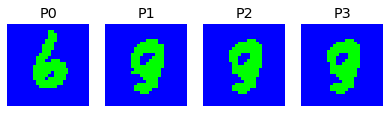

9


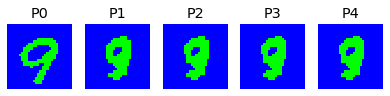

9


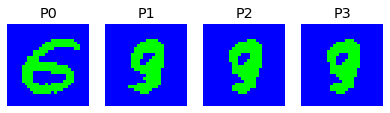

9


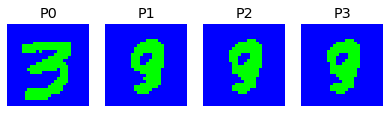

9


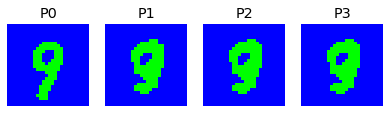

9


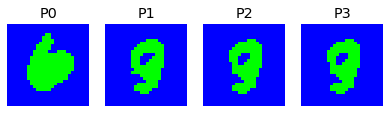

9


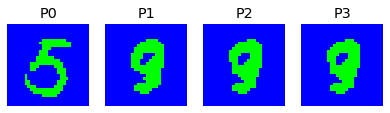

9


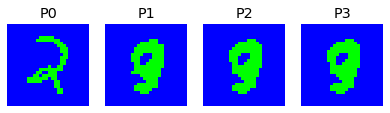

9


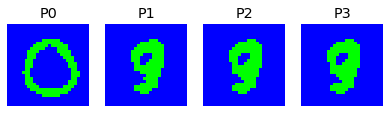

9


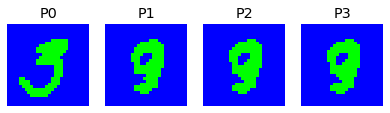

9


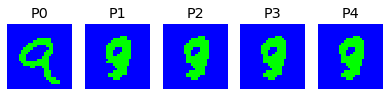

9


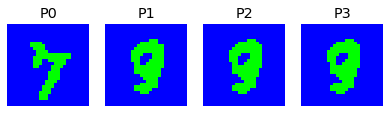

9


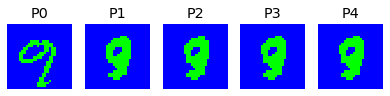

9


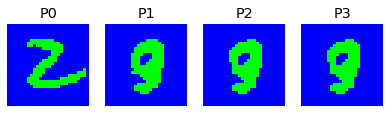

9


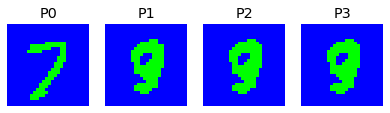

9


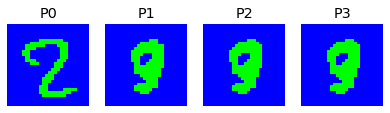

9


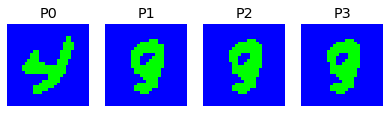

9


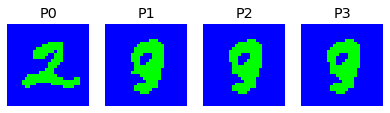

9


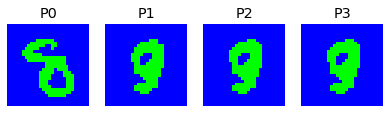

9


In [208]:
demo_size = 100
demo_idx = np.random.choice(60000, demo_size, replace = False)

out_class = np.zeros(demo_size)
for i in range(demo_size):
    idx0 = demo_idx[i]
    temp = conv_hopfield_mnist(mnist_weights, convert_binary(train_img[idx0]))
    digit = classify_mnist(mnist_patterns, temp[-1])
    print(digit)
    
    out_class[i] = digit

In [209]:
#checking accuracy for the demo:
cnt = 0
for i in range(demo_size):
    if out_class[i] == train_lab[demo_idx[i]]:
        cnt += 1

demo_acc = (cnt/demo_size)*100
print('Accuracy is ' + str(np.round(demo_acc,2)) + '%')


Accuracy is 13.0%


## Finally, trying out the MNIST test set:

In [210]:
#Initializing the network and storing weights:
mnist_weights = init_hopfield(mnist_patterns)
print('Reminder: Threshold used is ' + str(thresh))

Reminder: Threshold used is 85


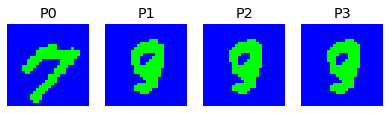

9


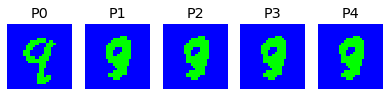

9


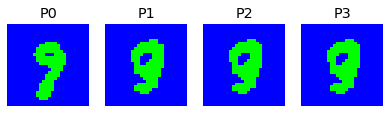

9


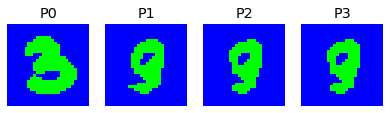

9


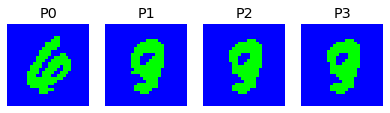

9


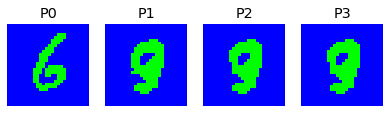

9


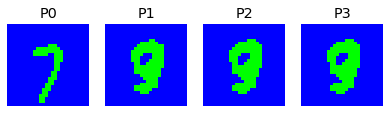

9


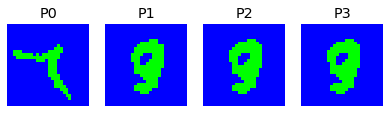

9


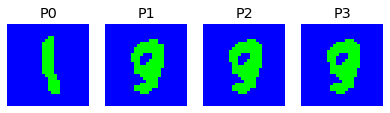

9


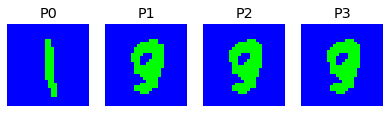

9


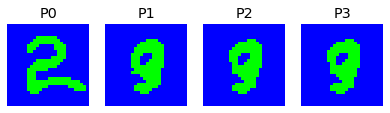

9


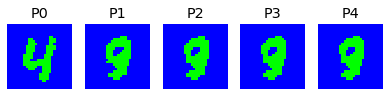

9


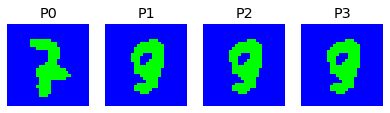

9


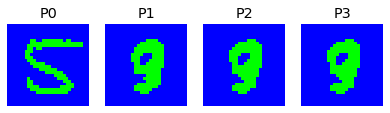

9


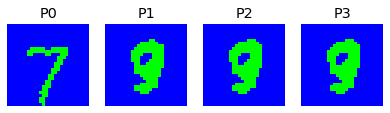

9


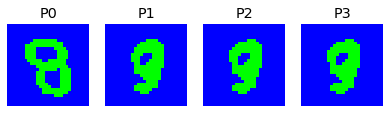

9


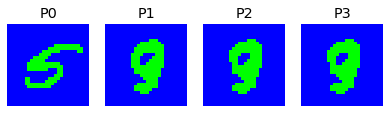

9


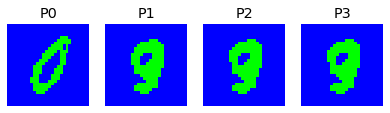

9


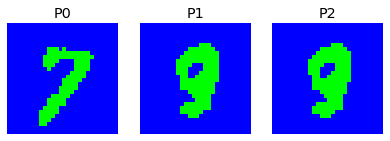

9


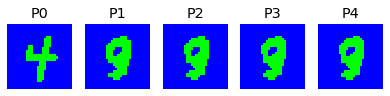

9


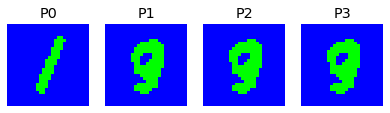

9


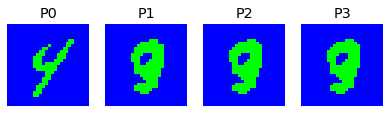

9


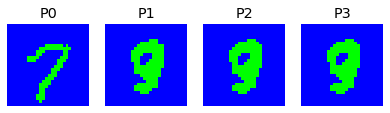

9


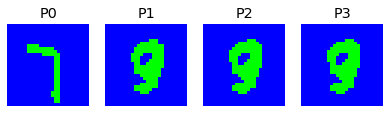

9


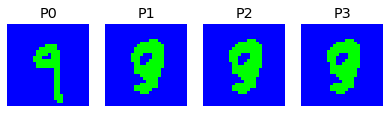

9


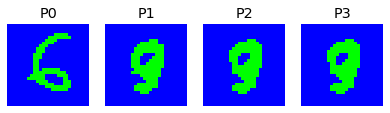

9


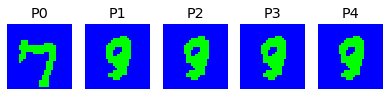

9


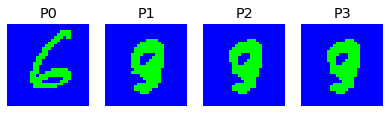

9


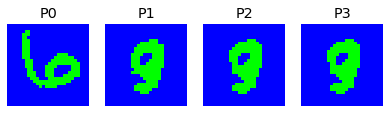

9


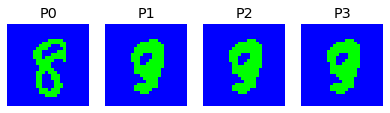

9


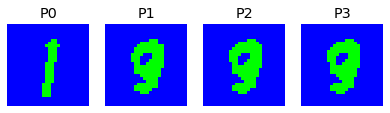

9


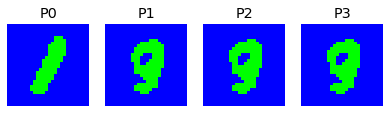

9


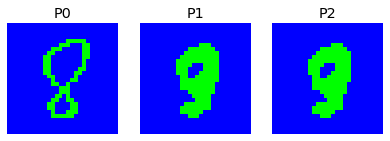

9


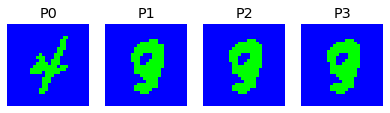

9


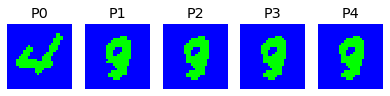

9


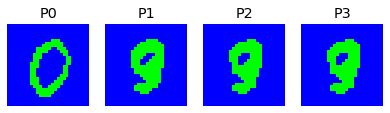

9


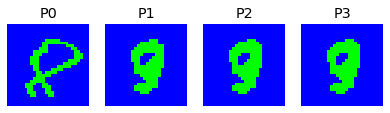

9


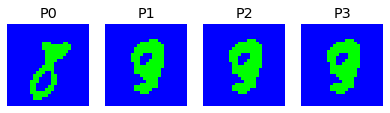

9


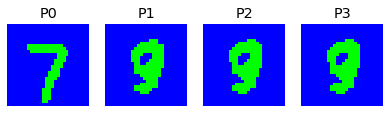

9


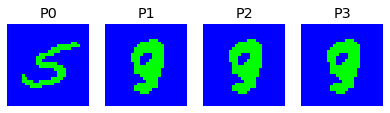

9


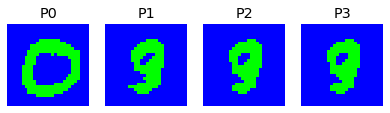

9


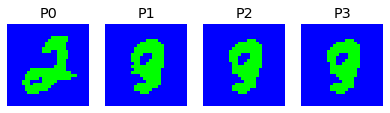

9


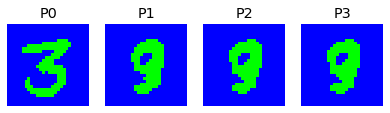

9


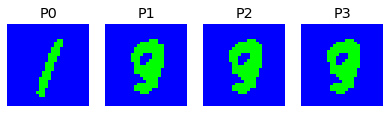

9


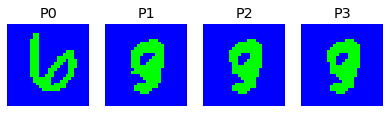

9


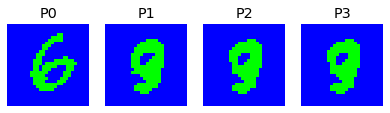

9


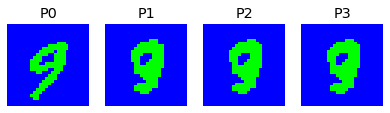

9


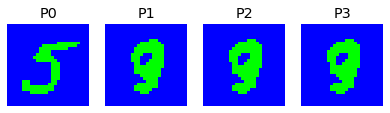

9


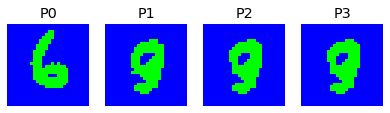

9


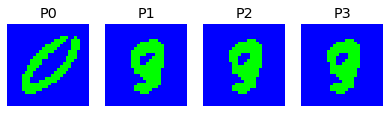

9


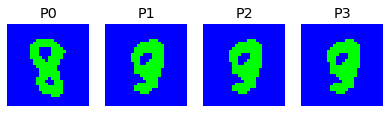

9


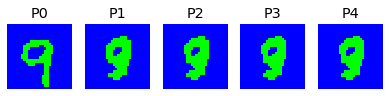

9


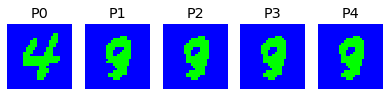

9


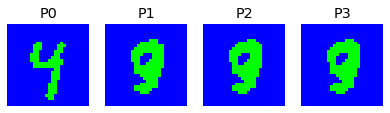

9


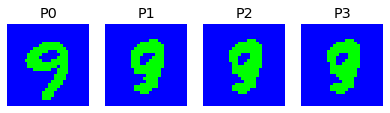

9


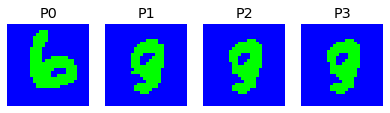

9


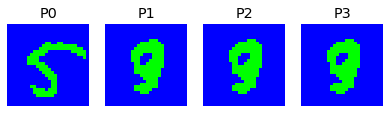

9


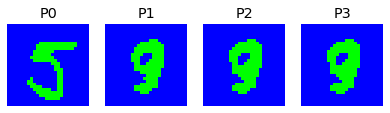

9


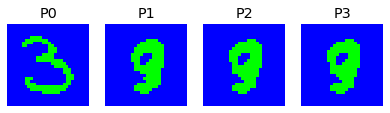

9


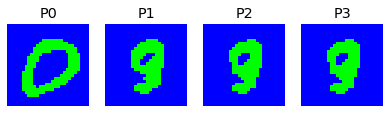

9


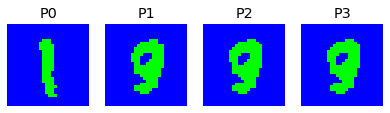

9


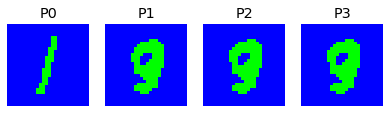

9


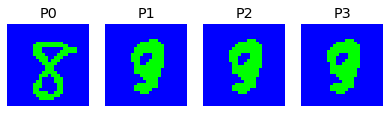

9


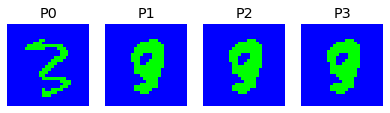

9


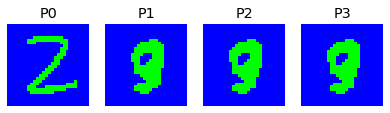

9


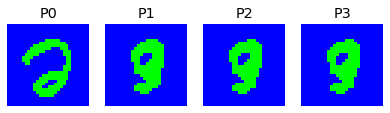

9


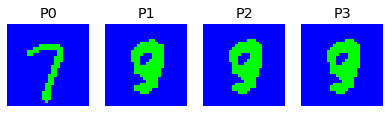

9


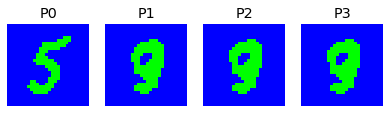

9


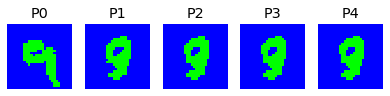

9


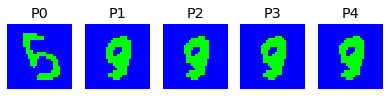

9


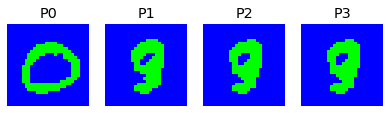

9


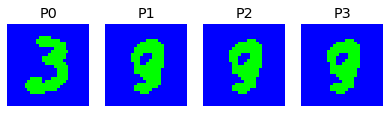

9


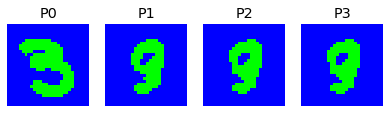

9


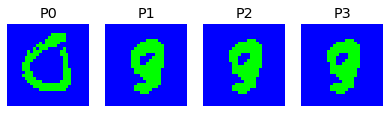

9


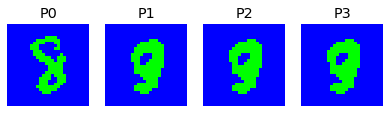

9


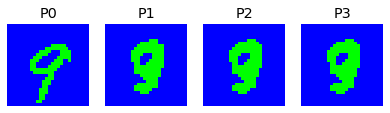

9


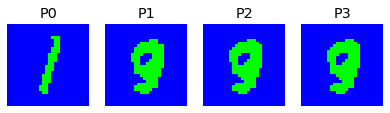

9


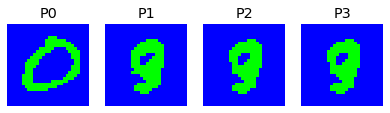

9


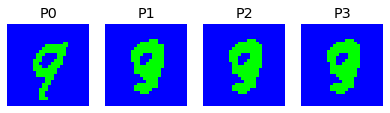

9


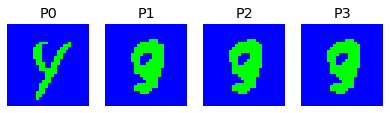

9


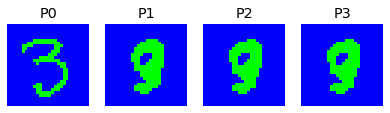

9


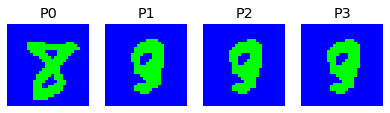

9


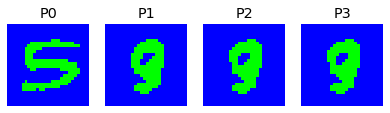

9


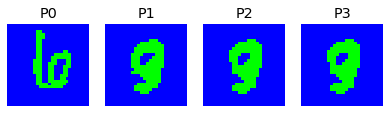

9


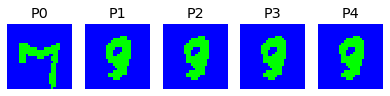

9


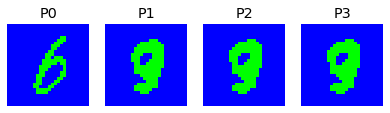

9


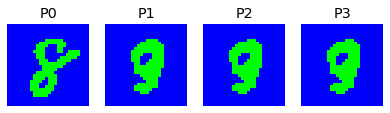

9


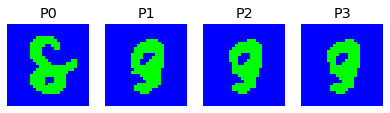

9


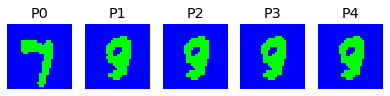

9


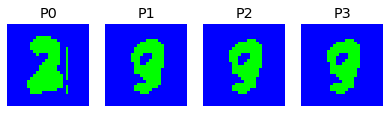

9


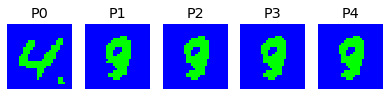

9


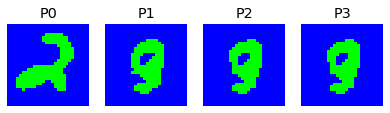

9


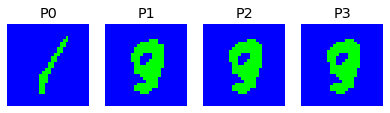

9


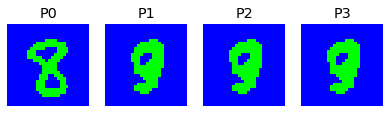

9


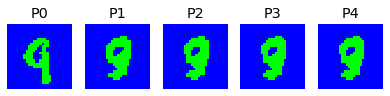

9


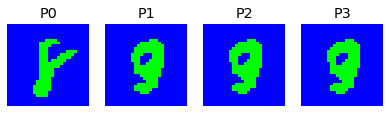

9


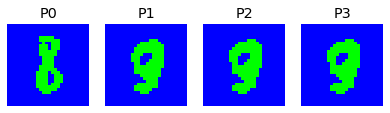

9


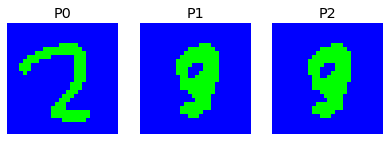

9


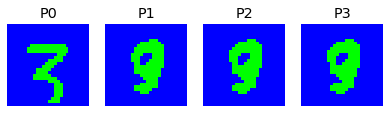

9


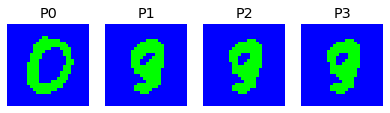

9


In [201]:
test_size = 100
test_idx = np.random.choice(10000, test_size, replace = False)

test_class_true = np.zeros(test_size) 
test_class_out = np.zeros(test_size)

for i in range(test_size):
    idx0 = test_idx[i]
    temp = conv_hopfield_mnist(mnist_weights, convert_binary(test_img[idx0]), plot = True)
    digit = classify_mnist(mnist_patterns, temp[-1])
    print(digit)
    
    test_class_out[i] = digit
    test_class_true[i] = test_lab[idx0] 
    
    
    

In [205]:
#checking accuracy for the test:
test_count = 0
for i in range(test_size): 
    if test_class_out[i] == test_lab[test_idx[i]]:
        test_count += 1

test_acc = (test_count/test_size)*100
print('Accuracy is ' + str(np.round(test_acc,2)) + '%')

Accuracy is 10.0%


Since it seems as though the asynchronous network only converges to 9, we should expect around a 10% accuracy if it only spits out 9. Here are the frequency of 9's in the random test set chosen above:

In [206]:
#cnt0 = 0
cnt9 = 0
for i in range(test_size):
    if test_lab[test_idx[i]] == 0:
        cnt0 += 1
    elif test_lab[test_idx[i]] == 9:
        cnt9 += 1
    
#freq0 = (cnt0/test_size)*100
freq9 = (cnt9/test_size)*100

#print('Frequency of 0: ' + str(np.round(freq0,2)) + ' %')
print('Frequency of 9: ' + str(np.round(freq9,2)) + ' %')
#print('Combined Frequency: ' + str(np.round(freq0+freq9,2)) + ' %')

Frequency of 9: 10.0 %


 **F1-score for test set:**

In [207]:
f1_score(test_class_true, test_class_out, average='micro')

0.10000000000000002

**Remarks:** I tried different threshholds and memorizing only 1 image per digit, but the same thing happens - the patterns always converge to 9 and rarely 0 *visually*, while the classifier sometimes classifies it as always 8 under some hyperparamters (threshhold =60). 

A threshold > 100 barely has any of the long slender lines like on 1s and 7s in the weighted images, while a lower one like 60 is just a blob of ink. 

With no preprocessing and just tinkering with hyperparameters here, the classificaltion could not be improved. There are a few things to note about Hopfield Network as classifiers:

1. It is blind to shapes, edges, angles or anything visual. We can interpret the squarely arranged pixels as images but the network and its evolution doesn't encode any spatial arrangement between the pixels. So random permutation to all the memorized patterns would have no effect on the network other than converging to patterns with the respective permutation applied. But to us a random permutation of 0 or 8 would simply be noise in a 28x28 resolution. 

2. The network doesn't really classify but converges to a pattern of activation. To get a class for the final image I used overlapping by seeing on average the images of which digit in the memorized patterns most matched the final coverged pattern. The network almost never converges exactly to one of the memorized images. A different method to classify *might* improve accuracy a bit but the bigger concern is that even visually the network always converges to 9s and rarely 0s.

3. NNs like CNN would take edges and shapes into account and the linked networks have reported >98% accuracy.  

### Method 1

1. Skew correct MNIST
2. Binarize by thresholding
3. Crop Image to 13x13
4. Store 1 image per digit in the Hopfield Network. For inference, Query the test image, and similarity match the network evolution after only 1 step, to give the output

In [ ]:
'''Code adapted from https://fsix.github.io/mnist/Deskewing.html'''

from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i]))
    return np.array(currents)

In [ ]:
deskewed_train = deskewAll(train_images)
deskewed_test = deskewAll(test_images)

In [ ]:
# Vary the threshold
thresholds = [5*i for i in range(50)]
# thresholds = [10]
acc = []
pattern_size = 13
max_a = 0
for threshold in thresholds:
    deskewed_train_t = (deskewed_train>threshold).astype(int)*2-1
    deskewed_test_t = (deskewed_test>threshold).astype(int)*2-1
    
    reduced_train = deskewed_train_t[:,8:21,8:21]
    reduced_test = deskewed_test_t[:,8:21,8:21]
    
    mnist_list = []
    for i in range(10):
        for j in range(len(train_images)):
            if train_labels[j] == i:
                mnist_list.append(reduced_train[j])
                break
                
    wghts = calculate_weights(mnist_list, pattern_size)

    preds = []
    for i in range(len(test_images)):    
        S = reduced_test[i]
        state_list =[S]
        for i in range(1):
            state_list.append(network_evolution(S,wghts))
        max_score = 0
        for j in range(10):
            score = (state_list[1]*mnist_list[j]).sum()
            if score>max_score:
                max_score = score
                pred = j
                if j>9:
                    pred = j-10
        preds.append(pred)
    preds_np = np.array(preds)
    accuracy = ((preds_np==test_labels).sum()/len(test_labels))
    acc.append(accuracy)
    if accuracy> max_a:
        preds_best = preds_np
        max_a = accuracy
    
    

In [ ]:
max_a

0.5936

Text(0, 0.5, 'Accuracy')

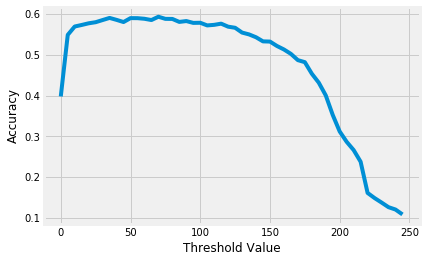

In [ ]:
plt.plot(thresholds, acc)
plt.xlabel("Threshold Value")
plt.ylabel("Accuracy")

In [ ]:
np.argmax(preds_best)*5

30

We see optimal thresholding occurs at 30, but fairly remains uniform till 70 performance wise

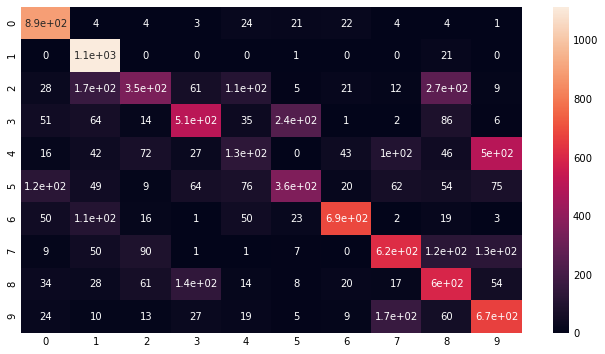

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm2 = confusion_matrix(test_labels, preds_best)

# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
# import matplotlib.pyplot as plt
array = cm2
df_cm = pd.DataFrame(array, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
# df_cm = pd.pivot_table(df_cm, index='country', columns='year')

plt.figure(figsize = (10,6))
# plt.ylabel("True Label")
sn.heatmap(df_cm, annot=True)

**Comments**: We see a fairly balance confusion matrix except - Many (in fact the majority) 4 are being predicted as 9 (they also look similar), many 2 are being mapped to 8, and many 3 are being maaped to 5.

**Note** Vertical axis is True label, Horizontal is Predicted values

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, preds_best))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       980
           1       0.68      0.98      0.80      1135
           2       0.56      0.34      0.42      1032
           3       0.61      0.50      0.55      1010
           4       0.29      0.13      0.18       982
           5       0.54      0.40      0.46       892
           6       0.83      0.72      0.77       958
           7       0.63      0.60      0.62      1028
           8       0.47      0.61      0.53       974
           9       0.46      0.67      0.55      1009

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.57     10000
weighted avg       0.58      0.59      0.57     10000



Method 1 Final Accuracy: **59.36%**